## Cartpole using DQN
## This implementation is adopted from Dr. Kolby Nottingham from Indylab, UC Irvine with slight modification

## optimize using bellman equation: $Q(s,a)=r + \gamma \underset{a'\sim A}{max} Q(s',a')$
## optimal form $ q(s,a;\theta^*)= E[Q(s,a)]$

## vanilla DQN algorithm pseudocode
## init Q network: $q(s,a;\theta_1)$
## init target Q network: $q(s',a';\theta_2), \theta_2 = \theta_1$
## for every state transition: $Loss=\frac{1}{N}\sum \bigg(J(q(s,a; \theta_1), (r + \gamma \underset{a'\sim A}{max} q(s',a';\theta_2)(1-done))\bigg)$
## $\theta_1 \leftarrow Optimize(Loss, \theta_1)$
## every once in a while: $\theta_2 \leftarrow \theta_1$

In [25]:
# env
import gym

# nn
import torch
import torch.nn as nn

# tools
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

## An example Q network

In [8]:
class QNetwork(nn.Module):

    def __init__(self, state_size, action_size):
        super().__init__()
        hidden_size = 8
        self.net = nn.Sequential(
            nn.Linear(state_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, action_size)
        )
    
    def forward(self, x):
        """
        Estimate q-values given state

          Args:
              x (tensor): current state, size (batch x state_size)

          Returns:
              q-values (tensor): estimated q-values, size (batch x action_size)
        """
        return self.net(x)

In [38]:
class DQNAgent:

    def __init__(self, Qnet, targetnet, gamma, lossfn, optim):
        self.Qnet = Qnet
        self.targetnet = targetnet
        self.gamma = gamma
        self.lossfn = lossfn
        self.optim = optim

    def train(self, s0, a0, s1, r, done):
        self.optim.zero_grad()
        # calculate loss
        Qsa = self.Qnet(s0).gather(1, a0.unsqueeze(-1)).squeeze(-1)     # Q(s , a )
        Qsanext = torch.max(self.targetnet(s1), 1)[0]                   # max a' Q(s', a')
        target = r + self.gamma * Qsanext * (1 - done)                  # r + gamma * max a' Q(s', a')
        loss = torch.mean(self.lossfn(Qsa, target))                     # loss = lossfn(Yhat= Q(s, a), Y= r + gamma * max a' Q(s', a'))
        # optimization step
        loss.backward()
        self.optim.step()

    def updatetarget(self):
        self.targetnet.load_state_dict(self.Qnet.state_dict())

    def infer(self, x, epsilon, verbose=0):
        with torch.no_grad():
            if random.random() < epsilon:
                return random.randint(0, 1)
            else:
                x = torch.tensor(x).float().unsqueeze(0).to(device)
                Qhat = self.Qnet(x)
                if verbose > 0:
                    print(Qhat)
                return torch.argmax(Qhat).item()

In [39]:
class ReplayBuffer:
    def __init__(self):
        self.memory = []

    def record(self, data):
        self.memory.append(data)

    def prepare_batch(self, batch_size, device):
        """
            Randomly sample batch from memory
            Prepare cuda tensors

            Args:
                memory (list): state, action, next_state, reward, done tuples
                batch_size (int): amount of memory to sample into a batch

            Returns:
                state (tensor): float cuda tensor of size (batch_size x state_size()
                action (tensor): long tensor of size (batch_size)
                next_state (tensor): float cuda tensor of size (batch_size x state_size)
                reward (tensor): float cuda tensor of size (batch_size)
                done (tensor): float cuda tensor of size (batch_size)
        """
        batch_data = random.sample(self.memory, batch_size if batch_size < len(self.memory) else len(self.memory))
        state_ = torch.tensor([x[0] for x in batch_data], dtype=torch.float, device=device)
        action_ = torch.tensor([x[1] for x in batch_data], dtype=torch.long, device=device)
        next_state_ = torch.tensor([x[2] for x in batch_data], dtype=torch.float, device=device)
        reward_ = torch.tensor([x[3] for x in batch_data], dtype=torch.float, device=device)
        done_ = torch.tensor([x[4] for x in batch_data], dtype=torch.float, device=device)
        
        return state_, action_, next_state_, reward_, done_

In [44]:
# Hyper parameters
lr = 1e-3
lossfn = torch.nn.functional.mse_loss
epochs = 800
start_training = 1000
gamma = 0.99
batch_size = 32

epsilon = 1
epsilon_decay = .9999

target_update = 1000
learn_frequency = 2
device = 'cuda'

# Init environment
state_size = 4
action_size = 2
env = gym.make('CartPole-v1', )

# Init networks
q_network = QNetwork(state_size, action_size).to(device)
target_network = QNetwork(state_size, action_size).to(device)

# Init optimizer
optim = torch.optim.Adam(q_network.parameters(), lr=lr)

# Init Learning Agent
learner = DQNAgent(q_network, target_network, gamma, lossfn, optim)
learner.updatetarget()

# Init replay buffer
memory = ReplayBuffer()

# Begin main loop
results_dqn = []
global_step = 0
loop = tqdm(total=epochs, position=0, leave=False)
for epoch in range(epochs):

  # Reset environment
  state = env.reset()
  done = False
  cum_reward = 0  # Track cumulative reward per episode

  # Begin episode
  while not done and cum_reward < 200:  # End after 200 steps 
    # Select e-greedy action
    action = learner.infer(state, epsilon)
    epsilon *= epsilon_decay

    # perform action, receive next observation
    next_state, reward, done, _ = env.step(action)

    # env.render()

    # Store transition (s0, a0, s1, r, done) in replay buffer
    memory.record((state, action, next_state, reward, done))

    # 
    cum_reward += reward
    global_step += 1  # Increment total steps
    state = next_state  # Set current state

    # train for every learn_frequency
    if global_step > start_training and global_step % learn_frequency == 0:

      # Sample batch
      batch = memory.prepare_batch(batch_size, device)
      
      # Train
      learner.train(*batch)

      if global_step % target_update == 0:
          learner.updatetarget()

  # Print results at end of episode
  results_dqn.append(cum_reward)
  loop.update(1)
  loop.set_description('Episodes: {} Reward: {}'.format(epoch, cum_reward))

Episodes: 799 Reward: 200.0: 100%|██████████| 800/800 [01:55<00:00,  2.88it/s]

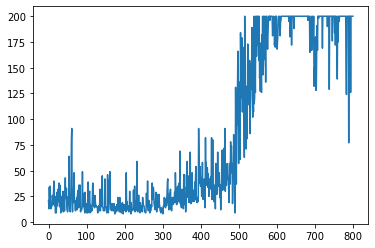

In [45]:
plt.plot(results_dqn)
plt.show()

In [42]:
import time

def playGame(env, agent, exploration=0, decay=0.9999, maxstep=500, wait=0, render=False):
    """ use screen as observation """
    
    # output data
    observations = []
    actions = []

    # start the game
    observation = env.reset()
    for t in range(maxstep):
        
        if render:
            env.render()

        observations.append(observation)

        # introduce randomness
        action = None
        if random.random() > exploration:
            action = agent.infer(observations[-1], exploration, verbose=1)
        else:
            action = inferRandom()
        exploration *= decay
        
        # record the observation-action pair
        actions.append(action)

        # get the next tick of game
        observation, reward, done, info = env.step(action)

        # record the reward
        if done:
            break
            
        # wait to render next frame
        time.sleep(wait)
    
    total_reward = t + 1
    return observations, actions, total_reward, exploration

def evaluate(env, learner, size):
    totalrewards = []
    actions = []
    for i_episode in range(size):
        O, A, R, epsilon = playGame(env, learner, exploration=0, render=False)
        # print(f'episode {i_episode} reward {reward}')
        actions.extend(A)
        totalrewards.append(R)
    return totalrewards

evaluate(env, learner, 10)

([[13.8218, 13.7334]], device='cuda:0')
tensor([[13.7382, 13.9400]], device='cuda:0')
tensor([[13.6257, 13.3860]], device='cuda:0')
tensor([[13.6311, 13.7672]], device='cuda:0')
tensor([[13.3601, 12.8442]], device='cuda:0')
tensor([[13.5427, 13.5912]], device='cuda:0')
tensor([[13.0719, 12.2067]], device='cuda:0')
tensor([[13.4188, 13.2886]], device='cuda:0')
tensor([[13.3716, 13.6008]], device='cuda:0')
tensor([[13.1459, 12.8254]], device='cuda:0')
tensor([[13.2286, 13.3999]], device='cuda:0')
tensor([[12.8556, 12.2778]], device='cuda:0')
tensor([[13.1071, 13.1979]], device='cuda:0')
tensor([[12.5434, 11.6323]], device='cuda:0')
tensor([[12.8773, 12.7061]], device='cuda:0')
tensor([[12.8909, 13.1706]], device='cuda:0')
tensor([[12.5808, 12.2303]], device='cuda:0')
tensor([[12.7205, 12.9472]], device='cuda:0')
tensor([[12.2670, 11.6669]], device='cuda:0')
tensor([[12.5735, 12.7235]], device='cuda:0')
tensor([[11.9310, 11.0020]], device='cuda:0')
tensor([[12.2520, 12.0619]], device='cud

[137, 145, 144, 141, 138, 137, 135, 134, 130, 130]